# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651


In [2]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 3

In [3]:
sys.H.H_drives

3-element Vector{SparseMatrixCSC{ComplexF64, Int64}}:
 sparse([2, 1], [1, 2], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im], 2, 2)
 sparse([2, 1], [1, 2], ComplexF64[0.0 + 1.0im, 0.0 - 1.0im], 2, 2)
 sparse([1, 2], [1, 2], ComplexF64[1.0 + 0.0im, -1.0 + 0.0im], 2, 2)

Setup metrics

In [4]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    # (larger values indicate more accumulated error sensitivity)
    final_point = curve[end]
    return norm(final_point)
end

function width_robustness(system::AbstractQuantumSystem, traj::NamedTrajectory; thresh::Float64=0.999)
    F = 1.0
    drift = system.H.H_drift
    drive = system.H.H_drives
    pauls = [PAULIS.X, PAULIS.Y, PAULIS.Z]
    widths = []
    for i in 1:3
        ε = 0.0
        err = pauls[i]
        F = 1.0
        while (ε < 0.5 && F >= thresh)
            noisy_drift = drift + ε * err
            noisy_sys = QuantumSystem(noisy_drift, drive)
            F = unitary_rollout_fidelity(traj, noisy_sys)
            ε += 0.0001
        end
        push!(widths, ε)
    end
    return widths
end


width_robustness (generic function with 1 method)

In [5]:

# # Multiplicative error template
# # H = aX
# # H_drive_m = a -> a[1] * H_drive
# # H_vars_array = Function[H_drive_m]

# varsys_mult = VariationalQuantumSystem(
#     a -> [a[1] * PAULIS.X, a[2] * PAULIS.Y, a[3] * PAULIS.Z],
#     Function[a -> a[1] * PAULIS.X, a -> a[1] * PAULIS.X, a -> a[1] * PAULIS.X],
#     3
# )

# varsys_both = VariationalQuantumSystem(
#     a -> a[1] * PAULIS.X + a[2] * PAULIS.Y,
#     Function[a -> a[1] * PAULIS.X, a -> PAULIS.X],
#     2
# )

# varadd_prob = UnitaryVariationalProblem(
#         varsys_add, U_goal, T, Δt;
#         robust_times=[[T]],
#         dda_bound = 2.0,
#         piccolo_options=piccolo_opts
#     )
# solve!(varadd_prob, max_iter=250, print_level=5)

# varmult_prob = UnitaryVariationalProblem(
#         varsys_mult, U_goal, T, Δt;
#         robust_times=[[T]],
#         dda_bound = 2.0,
#         piccolo_options=piccolo_opts
#     )
# solve!(varmult_prob, max_iter=250, print_level=5)

# varboth_prob = UnitaryVariationalProblem(
#         varsys_both, U_goal, T, Δt;
#         robust_times=[[T]],
#         dda_bound = 2.0,
#         piccolo_options=piccolo_opts
#     )
# solve!(varboth_prob, max_iter=250, print_level=5)

# X_drive = sys.H.H_drives[1]
# Hₑ_mult = a -> a[1] * X_drive

# mult_prob = UnitaryToggleProblem(
#     sys, U_goal, T, Δt, Hₑ_mult;
#     piccolo_options=piccolo_opts
#     )
# solve!(mult_prob, max_iter=250, print_level=5)


# Hₑ_both = a -> PAULIS.X + a[1] * X_drive
# both_prob = UnitaryToggleProblem(
#     sys, U_goal, T, Δt, Hₑ_both;
#     piccolo_options=piccolo_opts
#     )
# solve!(both_prob, max_iter=250, print_level=5)



In [6]:
Random.seed!(5)

#Default
def = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; Q_t=1.0)
def_elapsed_time = @elapsed begin
solve!(def, max_iter=250, print_level=5)
end

# Adjoint
∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
varsys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)

var_prob = UnitaryVariationalProblem(
        varsys, U_goal, T, Δt;
        robust_times=[[T], [T], [T]],
        a_bound = 10.0,
        dda_bound = 10.0,
        piccolo_options=piccolo_opts
)

var_elapsed_time = @elapsed begin
solve!(var_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(var_prob, max_iter=25, print_level=5)
end

# Toggling
Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
tog_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_add;
    piccolo_options=piccolo_opts
)

tog_elapsed_time = @elapsed begin
solve!(tog_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(tog_prob, max_iter=25, print_level=5)
end

# Fast Toggling
Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
ftog_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_add;
    piccolo_options=piccolo_opts
)

ftog_elapsed_time = @elapsed begin
solve!(ftog_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(ftog_prob, max_iter=25, print_level=5)
end

# Universal
Hₑ_add = a -> [PAULIS.X, PAULIS.Y, PAULIS.Z]
uni_prob = UnitaryToggleProblem(
    sys, U_goal, T, Δt, Hₑ_add;
    piccolo_options=piccolo_opts
)

uni_elapsed_time = @elapsed begin
solve!(uni_prob, max_iter=500, print_level=5, options=IpoptOptions(eval_hessian=false))
solve!(uni_prob, max_iter=25, print_level=5)
end


    constructing UnitarySmoothPulseProblem...
	using integrator: DataType
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear sol

11.67447325

In [7]:
times = [def_elapsed_time, var_elapsed_time, tog_elapsed_time, ftog_elapsed_time, uni_elapsed_time]

5-element Vector{Float64}:
 10.672259792
 36.840809458
 18.63406625
 11.443076583
 11.67447325

In [8]:
# display(CairoMakie.plot(def.trajectory, :a))
# display(CairoMakie.plot(add_prob.trajectory, :a))
# display(CairoMakie.plot(mult_prob.trajectory, :a))
# display(CairoMakie.plot(both_prob.trajectory, :a))

In [9]:
prob_trajs = [def.trajectory, var_prob.trajectory, tog_prob.trajectory, ftog_prob.trajectory, uni_prob.trajectory]
prob_widths = [width_robustness(sys, traj) for traj in prob_trajs]

scrX = [space_curve_robustness(traj, GATES.H, PAULIS.X) for traj in prob_trajs]
scrY = [space_curve_robustness(traj, GATES.H, PAULIS.Y) for traj in prob_trajs]
scrZ = [space_curve_robustness(traj, GATES.H, PAULIS.Z) for traj in prob_trajs]

print(prob_widths)
print(scrX)
print(prob_widths)

Vector{Any}[[0.008200000000000006, 0.012199999999999982, 0.007700000000000007], [0.07350000000000108, 0.08700000000000147, 0.09390000000000166], [0.09370000000000166, 0.0568000000000006, 0.055600000000000566], [0.04320000000000021, 0.05570000000000057, 0.05230000000000047], [0.04210000000000018, 0.07380000000000109, 0.047200000000000325]][0.7580169580367033, 0.03850649956552812, 0.05008256551252576, 0.05150978130603184, 0.061392546545746815]Vector{Any}[[0.008200000000000006, 0.012199999999999982, 0.007700000000000007], [0.07350000000000108, 0.08700000000000147, 0.09390000000000166], [0.09370000000000166, 0.0568000000000006, 0.055600000000000566], [0.04320000000000021, 0.05570000000000057, 0.05230000000000047], [0.04210000000000018, 0.07380000000000109, 0.047200000000000325]]

In [10]:
# Formatted output for robustness comparison
method_names = ["Default", "Adjoint", "Toggling", "Fast Toggling", "Universal"]

println("=" ^ 80)
println("ROBUSTNESS COMPARISON")
println("=" ^ 80)

# Width Robustness Results
println("\n📊 WIDTH ROBUSTNESS (Error Tolerance Thresholds)")
println("-" ^ 60)
println("Method          | X-Error  | Y-Error  | Z-Error  | Average")
println("-" ^ 60)
for (i, method) in enumerate(method_names)
    widths = prob_widths[i]
    avg_width = mean(widths)
    @printf("%-15s | %8.4f | %8.4f | %8.4f | %8.4f\n", 
            method, widths[1], widths[2], widths[3], avg_width)
end

# Space Curve Robustness Results
println("\n🌌 SPACE CURVE ROBUSTNESS (Accumulated Error Sensitivity)")
println("-" ^ 60)
println("Method          | X-Sens   | Y-Sens   | Z-Sens   | Total")
println("-" ^ 60)
for (i, method) in enumerate(method_names)
    x_sens = scrX[i]
    y_sens = scrY[i]
    z_sens = scrZ[i]
    total_sens = sqrt(x_sens^2 + y_sens^2 + z_sens^2)
    @printf("%-15s | %8.4f | %8.4f | %8.4f | %8.4f\n", 
            method, x_sens, y_sens, z_sens, total_sens)
end

# Summary Rankings
println("\n🏆 RANKINGS (1 = Best)")
println("-" ^ 40)

# Width robustness ranking (higher is better)
width_averages = [mean(prob_widths[i]) for i in 1:5]
width_ranks = sortperm(width_averages, rev=true)
width_ranking = zeros(Int, 5)
width_ranking[width_ranks] = 1:5

# Space curve robustness ranking (lower is better)
total_sensitivities = [sqrt(scrX[i]^2 + scrY[i]^2 + scrZ[i]^2) for i in 1:5]
sens_ranks = sortperm(total_sensitivities)
sens_ranking = zeros(Int, 5)
sens_ranking[sens_ranks] = 1:5

println("Method          | Width Rank | Sensitivity Rank")
println("-" ^ 40)
for (i, method) in enumerate(method_names)
    @printf("%-15s |     %d      |       %d\n", 
            method, width_ranking[i], sens_ranking[i])
end

println("\n💡 INTERPRETATION:")
println("   Width Robustness: Higher values = more robust to errors")
println("   Space Curve Sensitivity: Lower values = less sensitive to accumulated errors")
println("=" ^ 80)

ROBUSTNESS COMPARISON

📊 WIDTH ROBUSTNESS (Error Tolerance Thresholds)
------------------------------------------------------------
Method          | X-Error  | Y-Error  | Z-Error  | Average
------------------------------------------------------------
Default         |   0.0082 |   0.0122 |   0.0077 |   0.0094
Adjoint         |   0.0735 |   0.0870 |   0.0939 |   0.0848
Toggling        |   0.0937 |   0.0568 |   0.0556 |   0.0687
Fast Toggling   |   0.0432 |   0.0557 |   0.0523 |   0.0504
Universal       |   0.0421 |   0.0738 |   0.0472 |   0.0544

🌌 SPACE CURVE ROBUSTNESS (Accumulated Error Sensitivity)
------------------------------------------------------------
Method          | X-Sens   | Y-Sens   | Z-Sens   | Total
------------------------------------------------------------
Default         |   0.7580 |   0.4864 |   0.8090 |   1.2106
Adjoint         |   0.0385 |   0.0102 |   0.0429 |   0.0586
Toggling        |   0.0501 |   0.0688 |   0.0409 |   0.0945
Fast Toggling   |   0.0515 |   

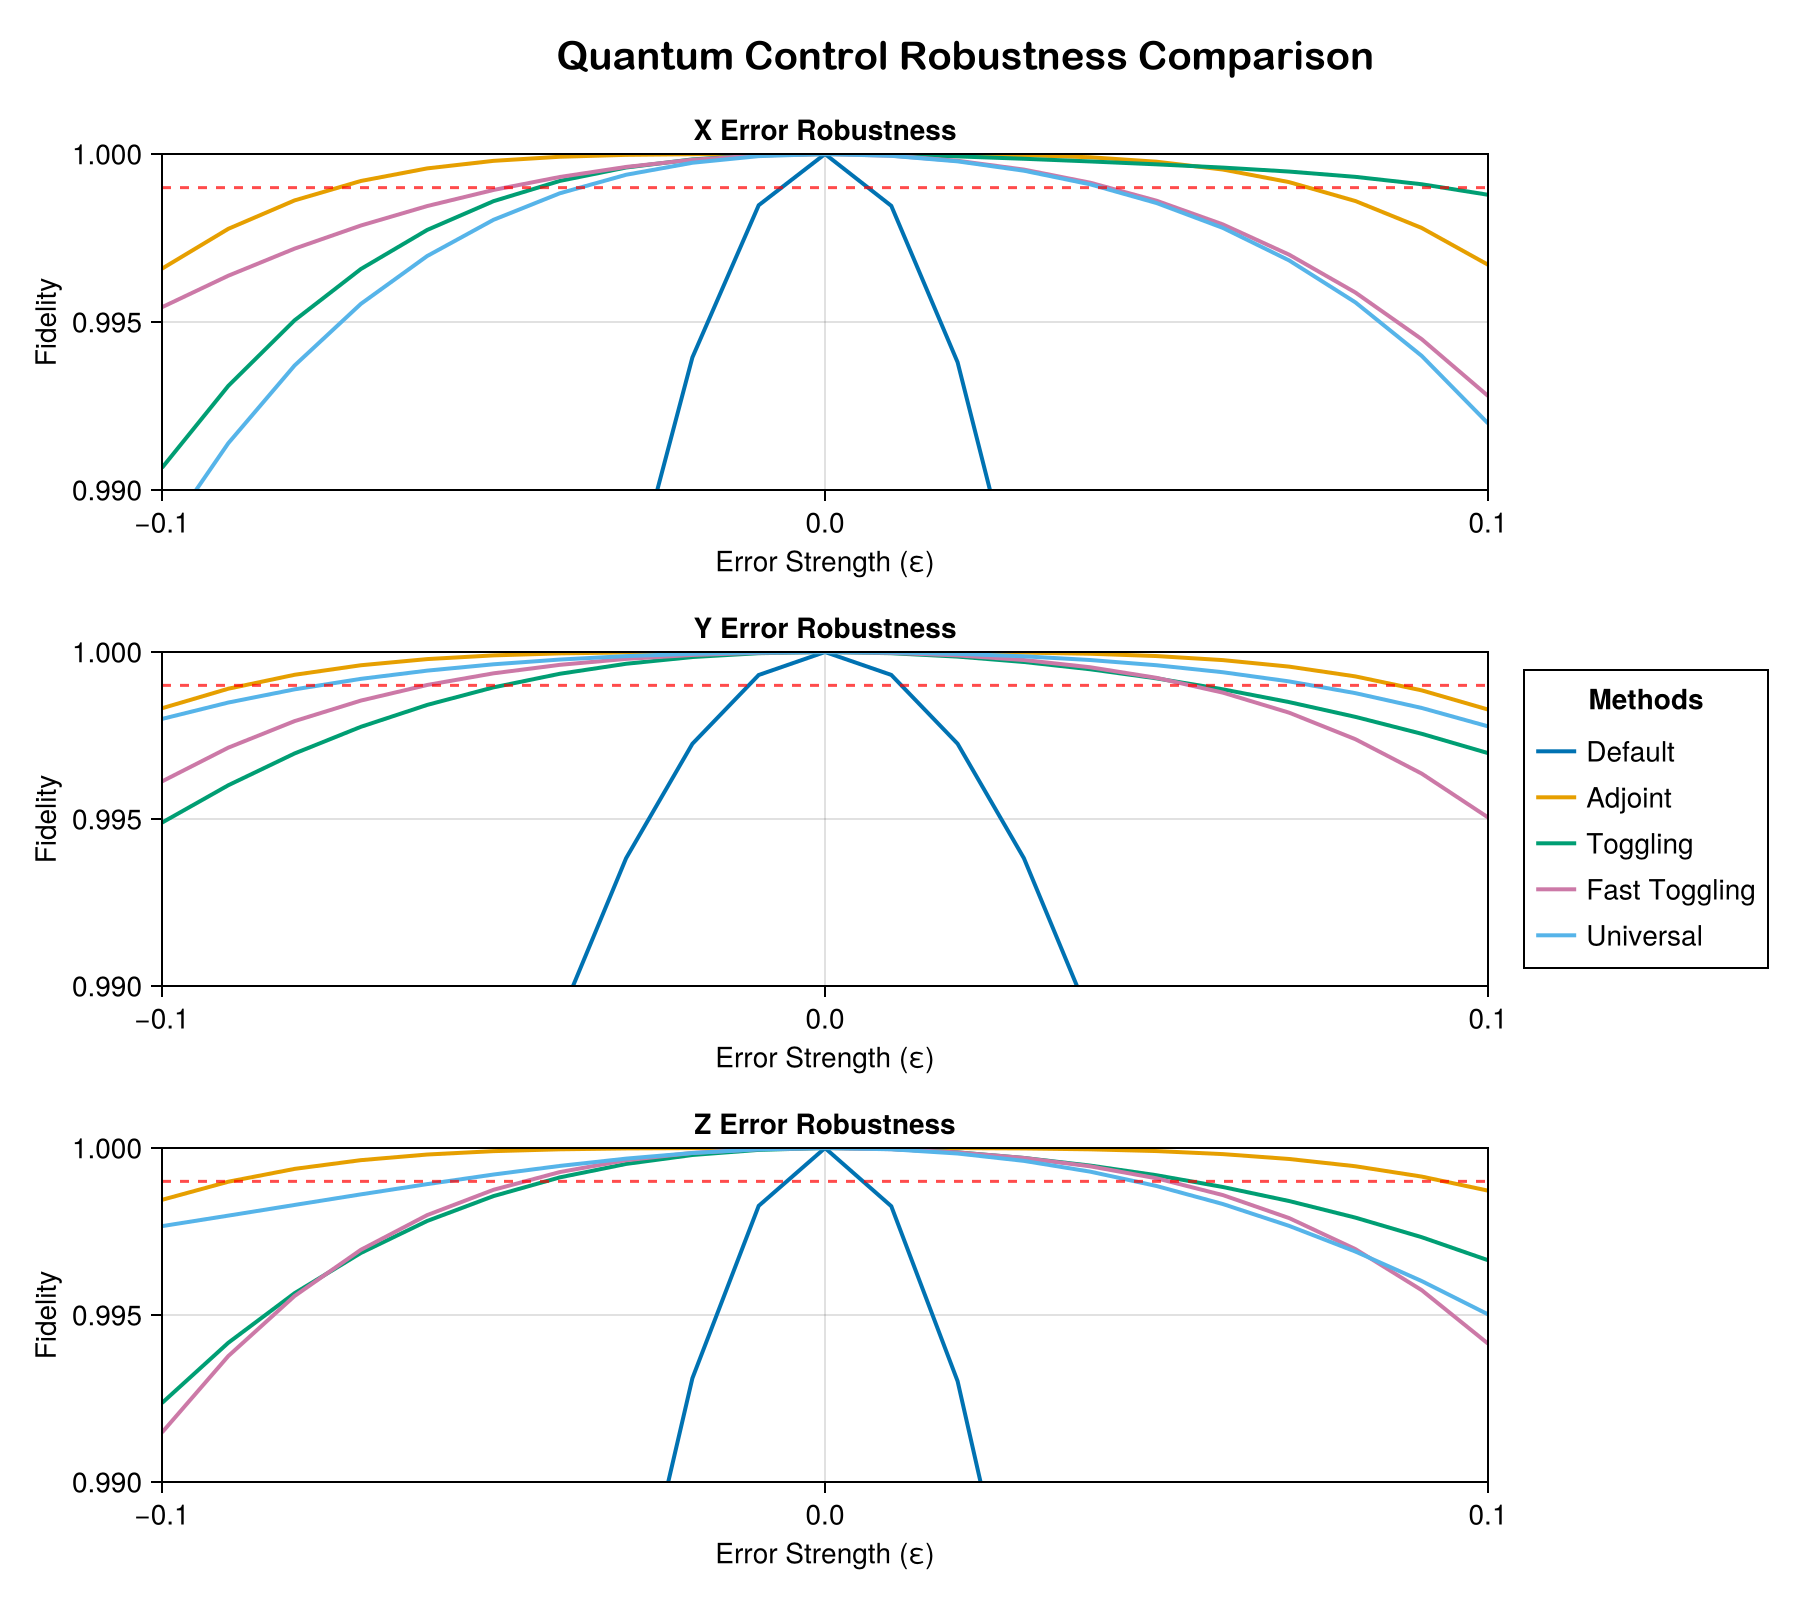

In [11]:
using CairoMakie

H_drive_add = H_drive

f = Figure(size=(900, 800))
ax1 = Axis(f[1, 1], title="X Error Robustness", xlabel="Error Strength (ε)", ylabel="Fidelity")
ax2 = Axis(f[2, 1], title="Y Error Robustness", xlabel="Error Strength (ε)", ylabel="Fidelity")  
ax3 = Axis(f[3, 1], title="Z Error Robustness", xlabel="Error Strength (ε)", ylabel="Fidelity")

colors = Makie.wong_colors()
method_names = ["Default", "Adjoint", "Toggling", "Fast Toggling", "Universal"]
trajectories = [def.trajectory, var_prob.trajectory, tog_prob.trajectory, ftog_prob.trajectory, uni_prob.trajectory]

εs = -0.1:0.01:0.1
# X Error plots
for (i, traj) in enumerate(trajectories)
    ys = [unitary_rollout_fidelity(traj, QuantumSystem(sys.H.H_drift + ε * PAULIS.X, sys.H.H_drives)) for ε in εs]
    lines!(ax1, εs, ys, label=method_names[i], color=colors[i], linewidth=2)
end

# Y Error plots  
for (i, traj) in enumerate(trajectories)
    ys = [unitary_rollout_fidelity(traj, QuantumSystem(sys.H.H_drift + ε * PAULIS.Y, sys.H.H_drives)) for ε in εs]
    lines!(ax2, εs, ys, label=method_names[i], color=colors[i], linewidth=2)
end

# Z Error plots
for (i, traj) in enumerate(trajectories)
    ys = [unitary_rollout_fidelity(traj, QuantumSystem(sys.H.H_drift + ε * PAULIS.Z, sys.H.H_drives)) for ε in εs]
    lines!(ax3, εs, ys, label=method_names[i], color=colors[i], linewidth=2)
end

# Add horizontal line at fidelity threshold
hlines!(ax1, [0.999], color=:red, linestyle=:dash, alpha=0.7)
hlines!(ax2, [0.999], color=:red, linestyle=:dash, alpha=0.7) 
hlines!(ax3, [0.999], color=:red, linestyle=:dash, alpha=0.7)

# Set axis limits and formatting
for ax in [ax1, ax2, ax3]
    Makie.xlims!(ax, -0.1, 0.1)
    Makie.ylims!(ax, 0.99, 1.0)
    ax.ygridvisible = true
    ax.xgridvisible = true
end

# Add a single legend for all subplots
Legend(f[1:3, 2], ax1, "Methods", framevisible=true)

# Add overall title
Label(f[0, 1:2], "Quantum Control Robustness Comparison", 
fontsize=20, font="bold")

f